IMAGEM A SER RESTAURADA

In [1]:
# Imagem de entrada
FULL_IMG_NAME = 'img_0_original.jpg'

IMPORTS

In [2]:
import os

import numpy as np
from matplotlib import pyplot as plt
import cv2

import test
import mask
import roi
import utils

/home/izabel/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
[2018-11-11 21:34:24 @__init__.py:79] Set root logger. Unset logger with neuralgym.unset_logger().
[2018-11-11 21:34:24 @__init__.py:80] Saving logging to file: neuralgym_logs/20181111213424451382.


DEFINIÇÃO DE VARIÁVEIS E CAMINHOS

In [3]:
# Diretórios da imagem original, arquivos temp. e restauração final
IMG_DIR_PATH = './images/'
INTERM_DIR_PATH = './interm_files/'
INPAINT_DIR_PATH = './inpaints/'

# Verifica se existem os diretórios e cria os que não existem
if not os.path.exists(INTERM_DIR_PATH):
    os.mkdir(INTERM_DIR_PATH)
if not os.path.exists(INPAINT_DIR_PATH):
    os.mkdir(INPAINT_DIR_PATH)

# Define os caminhos para as imagens
IMG_EXTENSION = FULL_IMG_NAME[-4:]
IMG_NAME = FULL_IMG_NAME[:-4]

IMG_FILEPATH = IMG_DIR_PATH + FULL_IMG_NAME

CROP_FILEPATH = INTERM_DIR_PATH + IMG_NAME + '_crop' + IMG_EXTENSION
FACE_FILEPATH = INTERM_DIR_PATH + IMG_NAME + '_face' + IMG_EXTENSION

MASK_FACE_FILEPATH = INTERM_DIR_PATH + IMG_NAME + '_face_mask' + IMG_EXTENSION
MASK_IMG_FILEPATH = INTERM_DIR_PATH + IMG_NAME + '_img_mask' + IMG_EXTENSION

INPAINT_FACE_FILEPATH = INTERM_DIR_PATH + IMG_NAME + '_face_inpaint' + IMG_EXTENSION
INPAINT_FINAL_FILEPATH = INPAINT_DIR_PATH + IMG_NAME + '_inpaint' + IMG_EXTENSION

CHECKPOINT_DIR_PATH = './model_logs/release_celeba_256/'

VALIDAÇÃO DA IMAGEM DE ENTRADA

Validando a imagem de entrada...
Pronto.


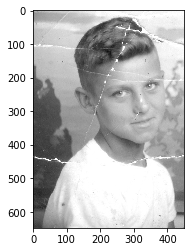

In [4]:
print('Validando a imagem de entrada...')
image = utils.validate_input_image(IMG_FILEPATH, IMG_EXTENSION)
utils.print_done()
plt.imshow(image)


IDENTIFICAÇÃO DO ROSTO

Identificando o rosto na imagem...
Pronto.


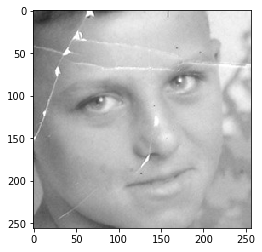

In [5]:
print('Identificando o rosto na imagem...')
try:
    # Identificação do rosto
    x, y, w, h = roi.identify_face(image)[0]
    
except:
    x = 0
    y = 0
    h, w, p = image.shape
    
    if w != h:
        min_size = min(w,h)
        if w == min_size:
            y = int(y + (h-w)/2)
            h = w
        elif h == min_size:
            x = int(x + (w-h)/2)
            w = h

image_copy = np.copy(image)
cv2.rectangle(image_copy, (x,y), (x+w,y+h), (255,0,0), 10)
plt.imshow(image_copy)

# Corte do rosto
image_cropped = image[y:y+h, x:x+w]
#     cv2.imwrite(CROP_FILEPATH, cv2.cvtColor(image_cropped, cv2.COLOR_BGR2RGB))
#     plt.imshow(image_cropped)

# Redimensionamento do rosto
face = utils.resize_face(w, h, image_cropped)
cv2.imwrite(FACE_FILEPATH, cv2.cvtColor(face, cv2.COLOR_BGR2RGB))
plt.imshow(face)

utils.print_done()

IDENTIFICAÇÃO DOS OLHOS

Identificando os olhos...
Pronto.


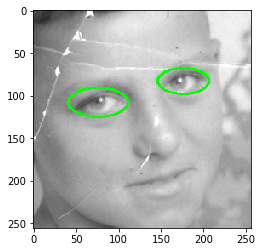

In [6]:
print('Identificando os olhos...')
true_eyes = roi.detect_eyes(face)

face_copy = np.copy(face)
for (ex, ey, ew, eh) in true_eyes:
    cv2.ellipse(face_copy,(int(ex+0.5*ew), int(ey+0.5*eh)),(int(ew/2),int(eh/4)),0,0,360,(0, 255, 0),2)

plt.imshow(face_copy)
utils.print_done()

CRIAÇÃO DA MÁSCARA PARA O ROSTO (máscara em branco: 0 = preto, 255 = branco)

Criando a máscara para o rosto...
Pronto.


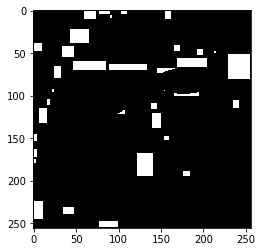

In [7]:
print('Criando a máscara para o rosto...')
face_rect_mask = mask.get_rect_mask(face)

face_mask = mask.get_mask(face)
mask.remove_eyes_from_mask(face_mask, true_eyes)
mixed = ~face_rect_mask & face_mask

mask.remove_eyes_from_mask(face_rect_mask, true_eyes)
mask.remove_border_from_mask(face_rect_mask)
cv2.imwrite(MASK_FACE_FILEPATH, face_rect_mask)
plt.imshow(face_rect_mask, cmap='gray')

utils.print_done()

VERIFICAÇÃO DA PORCENTAGEM DE DANO NO ROSTO

In [8]:
# print('Verificando a porcentagem de dano no rosto...')

# sem_dano = sum(sum(face_rect_mask == 0))
# porcentagem_dano = 1-sem_dano/utils.FACE_SIZE**2
# print(str(round(porcentagem_dano, 2)*100) + '% de dano no rosto.')

RESTAURAÇÃO DO ROSTO

Restaurando o rosto com Generative Inpaint...
Pronto.


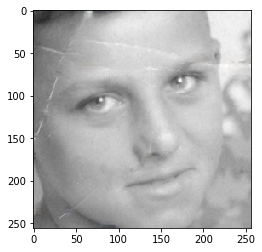

In [9]:
print('Restaurando o rosto com Generative Inpaint...')
face_inpaint = test.run_inpaint(image = FACE_FILEPATH,
                                 mask = MASK_FACE_FILEPATH,
                                 output = INPAINT_FACE_FILEPATH,
                                 checkpoint_dir = CHECKPOINT_DIR_PATH)
face_inpaint2 = cv2.inpaint(face, mixed, 3, cv2.INPAINT_TELEA)
face_inpaint[mixed==255] = face_inpaint2[mixed==255]

cv2.imwrite(INPAINT_FACE_FILEPATH, cv2.cvtColor(face_inpaint, cv2.COLOR_BGR2RGB))
plt.imshow(face_inpaint)

# Redimensionando o rosto restaurado para o tamanho original
face_inpaint_redim = cv2.resize(face_inpaint, (w, h), interpolation = cv2.INTER_AREA)

utils.print_done()

RESTAURAÇÃO DA IMAGEM DE FUNDO

Restaurando o fundo da imagem...


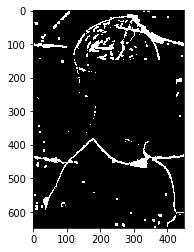

In [10]:
print('Restaurando o fundo da imagem...')
image_mask = mask.get_mask(image)
mask.remove_face_from_mask(image_mask, x, y, w, h)
# cv2.imwrite(MASK_IMG_FILEPATH, image_mask)
plt.imshow(image_mask, cmap='gray')

Pronto.


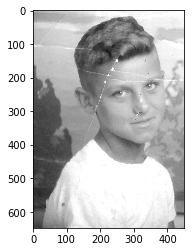

In [11]:
image_inpaint = cv2.inpaint(image, image_mask, 3, cv2.INPAINT_TELEA)
# cv2.imwrite(INPAINT_OPENCV_FILEPATH, cv2.cvtColor(image_inpaint, cv2.COLOR_BGR2RGB))
plt.imshow(image_inpaint, cmap='gray')

utils.print_done()

UNIÃO DO ROSTO COM A IMAGEM DE FUNDO

Reconstruindo a imagem completa...
Pronto.


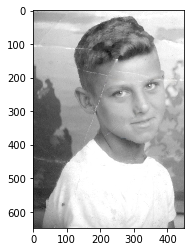

In [12]:
print('Reconstruindo a imagem completa...')

image_final = np.copy(image_inpaint)
image_final[y:y+h, x:x+w] = face_inpaint_redim

cv2.imwrite(INPAINT_FINAL_FILEPATH, cv2.cvtColor(image_final, cv2.COLOR_BGR2RGB))
plt.imshow(image_final)

utils.print_done()